# Report

#### Tasks distribution.
- **LZ77**, **Huffman Algorithm** implementations: **Mykola Vysotskyi**.
- **Deflate** implementation: **Natalia Skutar**. 
- **LZW** implementation: **Natalia Skutar** and **Mykola Vysotskyi**

### Base ```Compressor``` class

First of all, we have implemented a base class ```Compressor``` which is inherited by all other classes. It contains the following methods:
- ```compress``` - compresses the input file and writes the result to the output file.
- ```decompress``` - decompresses the input file and writes the result to the output file.

In [2]:
"""
Compressor base class.
This module contains the base class for all compressors. It is not meant to be used directly.
"""

class Compressor:
    """
    Base class for all compressors.
    """
    def compress(self, src: str, dest: str):
        """
        Compresses the content.
        """
        raise NotImplementedError('subclasses of Compressor must provide a compress() method')

    def decompress(self, src: str, dest: str):
        """
        Decompresses the content.
        """
        raise NotImplementedError('subclasses of Compressor must provide a decompress() method')


### LZ77 Algorithm

LZ77 is a lossless data compression algorithm. It is a dictionary-based algorithm, which means that it uses a dictionary of previously seen strings to find matches. The algorithm is based on the idea of finding the longest match between the current position in the input stream and the dictionary. The performance of compression in depent on the size of the dictionary. The larger the dictionary, the better the compression ratio, but the more time and memory is required to compress and decompress the data.

Int this implementation we encode **offset** with 2 bytes **length** with 1 byte and **next** with 1 byte. So the maximum size of the dictionary is **65536** bytes. The maximum length of the match is **256**.

In [56]:
"""
LZ77 compression algorithm.
"""

class LZ77(Compressor):
    """
    LZ77 compression algorithm.
    """
    def __init__(self, window_size=8192, lookahead_buffer_size=255):
        super().__init__()
        self._window_size = window_size
        self._window = b""
        self._lookahead_buffer_size = lookahead_buffer_size

    def _update_window(self, fpointer, match_length: int):
        """
        Updates the window.
        """
        self._window += fpointer.read(match_length)
        next_char = fpointer.read(1)

        if next_char:
            diff = len(self._window) - self._window_size
            self._window = self._window[max(0, diff):]
            self._window += next_char

            return next_char

        return b''

    def _longest_match(self, fpointer) -> tuple:
        """
        Finds the longest match between the window and the lookahead buffer.
        """
        offset = 0
        length = 0

        lookahead_buffer = fpointer.read(self._lookahead_buffer_size)
        bytes_read = len(lookahead_buffer)

        for i in range(1, bytes_read + 1):
            try:
                offset = len(self._window) - self._window.rindex(lookahead_buffer[:i])
                length = i
            except ValueError:
                break

        fpointer.seek(-bytes_read, 1)
        return offset, length, self._update_window(fpointer, length)

    def compress(self, src: str, dest: str):
        """
        Compresses the content.
        """
        self._window = b""

        with open(src, 'rb') as fpointer, open(dest, 'wb+') as out:
            while True:
                match_idx, match_length, next_char = self._longest_match(fpointer)

                out.write(match_idx.to_bytes(2, 'big'))
                out.write(match_length.to_bytes(1, 'big'))
                out.write(next_char)

                if not next_char:
                    break

    def _decompress(self, data: tuple, out_ptr):
        """
        Decompresses the content.

        Args:
            data (tuple): The data to decompress.
            out_ptr: The output file pointer.

        Returns:
            None
        """
        for offset, length, next_char in data:
            out_ptr.seek(-offset, 1)
            chunk = out_ptr.read(length) + next_char
            out_ptr.seek(offset - length, 1)
            out_ptr.write(chunk)

    def decompress(self, src: str, dest: str):
        """
        Decompresses the content.
        """
        with open(src, "rb") as in_ptr, open(dest, 'wb+') as out_ptr:
            data = []

            while True:
                offset = int.from_bytes(in_ptr.read(2), 'big')
                length = int.from_bytes(in_ptr.read(1), 'big')
                next_char = in_ptr.read(1)

                data.append((offset, length, next_char))

                if not next_char:
                    break

            self._decompress(data, out_ptr)


### LZW Algorithm

LZW - Lempel-Ziv-Welch algorithm is a lossless data compression algorithm. The algorithm is a variant of LZ77 algorithm. The main difference is that LZW uses a dictionary to store the substrings of the input file. The dictionary is a hash table where the key is the substring and the value is the index of the substring in the dictionary. The dictionary is initialized with all the possible substrings of the input file. We limit size of the dictionary to $2^{14}$ elemets.

In [50]:
"""
LZ77 compression algorithm.
"""

class LZ77(Compressor):
    """
    LZ77 compression algorithm.
    """
    def __init__(self, window_size=8192, lookahead_buffer_size=255):
        super().__init__()
        self._window_size = window_size
        self._window = b""
        self._lookahead_buffer_size = lookahead_buffer_size

    def _update_window(self, fpointer, match_length: int):
        """
        Updates the window.
        """
        self._window += fpointer.read(match_length)
        next_char = fpointer.read(1)

        if next_char:
            diff = len(self._window) - self._window_size
            self._window = self._window[max(0, diff):]
            self._window += next_char

            return next_char

        return b''

    def _longest_match(self, fpointer) -> tuple:
        """
        Finds the longest match between the window and the lookahead buffer.
        """
        offset = 0
        length = 0

        lookahead_buffer = fpointer.read(self._lookahead_buffer_size)
        bytes_read = len(lookahead_buffer)

        for i in range(1, bytes_read + 1):
            try:
                offset = len(self._window) - self._window.rindex(lookahead_buffer[:i])
                length = i
            except ValueError:
                break

        fpointer.seek(-bytes_read, 1)
        return offset, length, self._update_window(fpointer, length)

    def compress(self, src: str, dest: str):
        """
        Compresses the content.
        """
        self._window = b""

        with open(src, 'rb') as fpointer, open(dest, 'wb+') as out:
            while True:
                match_idx, match_length, next_char = self._longest_match(fpointer)

                out.write(match_idx.to_bytes(2, 'big'))
                out.write(match_length.to_bytes(1, 'big'))
                out.write(next_char)

                if not next_char:
                    break

    def _decompress(self, data: tuple):
        buffer = b""

        for offset, length, next_char in data:
            yield buffer[-offset:][:length] + next_char
            buffer += next_char

            if len(buffer) > self._window_size:
                buffer = buffer[-self._window_size:]

    def decompress(self, src: str, dest: str):
        """
        Decompresses the content.
        """
        with open(src, "rb") as in_ptr, open(dest, 'wb') as out_ptr:
            data = []

            while True:
                offset = int.from_bytes(in_ptr.read(2), 'big')
                length = int.from_bytes(in_ptr.read(1), 'big')
                next_char = in_ptr.read(1)

                data.append((offset, length, next_char))

                if not next_char:
                    break

            decompres_gen = self._decompress(data)

            while True:
                try:
                    out_ptr.write(next(decompres_gen))
                except StopIteration:
                    break


### Huffman encoding algorithm

Huffman algorithm is a lossless data compression algorithm. Lengths of the assigned codes are based on the frequencies of corresponding characters. The most frequent character gets the smallest code and the least frequent character gets the largest code. This implementation use ```heapq``` module to build a Huffman code. Encoded data is written to the output file as a sequence of bits.

Structure of the output file:
- First **N** bytes - dictionary. We use Pickle to store the dictionary.
- Next **1** byte - size of the last block to decode = **M**.
- Next **M** bytes - that last block.
- All next bytes - encoded data.

In [43]:
"""
Huffman algorithm implementation.
"""

from typing import Generator, Sequence
from heapq import heapify, heappop, heappush

import pickle
from math import log2

from collections import Counter
from itertools import chain

class HuffmanCode(Compressor):
    """
    Huffman algorithm implementation class.
    """
    def __init__(self) -> None:
        super().__init__()
        self.bits = self.bits_dict()

    def _generate_dict(self, probs_dict: dict) -> None:
        """
        Function that generates the dictionary of the probabilities.
        Used block coding with size 'block_size'.

        Args:
            probs_dict: dictionary of the probabilities.
            block_size: size of the block.

        Returns:
            Dictionary of the probabilities, entropy of the code.
        """
        heap = [[prob, [byte, b""]] for byte, prob in probs_dict.items()]
        heapify(heap)

        while len(heap) > 1:
            low = heappop(heap)
            high = heappop(heap)

            for pair in low[1:]:
                pair[1] = b"\0" + pair[1]

            for pair in high[1:]:
                pair[1] = b"\1" + pair[1]

            heappush(heap, [low[0] + high[0]] + low[1:] + high[1:])

        return dict(heappop(heap)[1:])

    def _encode(self, data: Sequence) -> tuple[int]:
        """
        Function that encodes the file.

        Args:
            data: data to encode.

        Returns:
            Tuple of the encoded data.
        """
        probs_dict = {key: value / len(data) for key, value in Counter(data).items()}
        huffman_code = self._generate_dict(probs_dict)

        code_sequence = chain.from_iterable(
            map(lambda byte: huffman_code[byte], data)
        )

        return tuple(code_sequence), huffman_code

    def _to_bits(self, code_sequence: Sequence, huffman_code: dict) -> Generator:
        """
        Function that transforms the code sequence to bits.

        Args:
            code_sequence: sequence of the codes.
            huffman_code: dictionary of the huffman code.

        Returns:
            Generator of the compressed data.
        """
        last_block_size = len(code_sequence) % 8
        last_block = code_sequence[-last_block_size:] if last_block_size else b""

        assert last_block_size <= 8 and len(last_block) == last_block_size

        yield {value: key for key, value in huffman_code.items()}

        yield last_block_size.to_bytes(1, "big")
        yield bytes(last_block)

        for idx in range(0, (len(code_sequence) // 8) * 8, 8):
            byte = 0

            for bit_idx in range(8):
                byte = (byte << 1) | code_sequence[idx + bit_idx]

            yield byte.to_bytes(1, "big")

    def compress(self, src: str, dest: str) -> None:
        """
        Function that compresses the file.
        """
        with open(src, "rb") as in_ptr, open(dest, "wb") as out_ptr:
            code_sequence, huffman_code = self._encode(in_ptr.read())
            compress_generator = self._to_bits(code_sequence, huffman_code)

            pickle.dump(next(compress_generator), out_ptr)

            while True:
                try:
                    out_ptr.write(next(compress_generator))
                except StopIteration:
                    break

    def _from_bits(self, data: bytes, huffman_code: dict, last_block: bytes) -> Generator:
        """
        Function that decodes the file.

        Args:
            data: data to decode.
            huffman_code: dictionary of the huffman code.

        Returns:
            Generator of the decoded data.
        """
        buffer = b""
        self.bits[None] = last_block

        for byte in data + [None]:
            bits = 8 if byte is not None else len(last_block)
            for idx in range(bits):
                buffer += self.bits[byte][idx: idx + 1]

                if buffer in huffman_code:
                    yield huffman_code[buffer]
                    buffer = b""

        assert buffer == b"", "Buffer is not empty!"

    def _decompress(self, src: str) -> Generator:
        """
        Function that decompresses the file.

        Args:
            data: data to decompress.

        Returns:
            Generator of the decompressed data.
        """
        with open(src, "rb") as in_ptr:
            huffman_code = pickle.load(in_ptr)

            last_block_size = int.from_bytes(in_ptr.read(1), "big")
            last_block = in_ptr.read(last_block_size)

            decode_generator = self._from_bits(list(in_ptr.read()), huffman_code, last_block)
            while True:
                try:
                    yield next(decode_generator)
                except StopIteration:
                    break

    def decompress(self, src: str, dest: str) -> None:
        """
        Function that decompresses the file.

        Args:
            data: data to decompress.
            dest: path to the decompressed file.
        """
        with open(dest, "wb") as out_ptr:
            data_generator = self._decompress(src)

            while True:
                try:
                    out_ptr.write(next(data_generator).to_bytes(1, "big"))
                except StopIteration:
                    break

    @staticmethod
    def bits_dict() -> dict[int, bytes]:
        """
        Function that generates the dictionary of the bits
        representation of the bytes.

        Args:
            None.

        Returns:
            Dictionary of the bits representation of the bytes.
        """
        result = {}

        for idx in range(256):
            bits = b""
            byte = idx

            for _ in range(8):
                bits = b"\0" + bits if byte & 1 == 0 else b"\1" + bits
                byte >>= 1

            result[idx] = bits

        return result

    @staticmethod
    def entropy(probs: tuple[float]) -> float:
        """
        Entropy of the code.
        """
        return sum(-prop * log2(prop) for prop in probs)


### Deflate algorithm

Deflate - is a combination of LZ77 and Huffman algorithms. The main idea of the algorithm is to compress the data in two steps. First, we use LZ77 algorithm to compress file and then we use Huffman algorithm to compress the result of the first step. The result of the second step is written to the output file.

In [57]:
"""
Deflate compression algorithm.
"""

import pickle

class Deflate(LZ77, HuffmanCode):
    """
    Deflate algorithm implementation class.
    """
    def __init__(self, window_size=512):
        super().__init__(window_size=window_size)

    def compress(self, src: str, dest: str):
        with open(src, "rb") as in_ptr, open(dest, "wb") as out_ptr:
            code_sequence = []

            while True:
                offset, length, next_char = self._longest_match(in_ptr)
                code_sequence.append((offset, length, next_char))

                if not next_char:
                    break

            code_sequence, huffman_code = HuffmanCode._encode(self, code_sequence)
            compress_generator = self._to_bits(code_sequence, huffman_code)
            pickle.dump(next(compress_generator), out_ptr)

            while True:
                try:
                    out_ptr.write(next(compress_generator))
                except StopIteration:
                    break

    def decompress(self, src: str, dest: str):
        """
        Decompresses the content.
        """
        with open(dest, "wb+") as out_ptr:
            code_sequence = HuffmanCode._decompress(self, src)
            LZ77._decompress(self, code_sequence, out_ptr)


## Testing

For testing we prepared a set of books in **.txt** format. Sizes of books is in range from **630 Kb** to **5.6 Mb**.

In [67]:
import os
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

test_set = [os.path.join("books", f"{idx}.txt") for idx in range(1, 6)]

algorithms = [LZ77(), LZW(), HuffmanCode()]

### Timing

In [68]:
from tempfile import NamedTemporaryFile
from timeit import default_timer

def time_size_check(algo: Compressor, filepath: str) -> tuple[tuple[float, float], tuple[float, float]]:
    """
    Function that checks the time of the compression and decompression.

    Args:
        algo: algorithm to check.
        filepath: file to test the algorithm.

    Returns:
        Tuple of the compression and decompression time.
    """
    or_size = os.path.getsize(filepath)

    tmp_file1 = NamedTemporaryFile(delete=False)
    tmp_file2 = NamedTemporaryFile(delete=False)

    start = default_timer()
    algo.compress(filepath, tmp_file1.name)
    end = default_timer()

    comp_size = os.path.getsize(tmp_file1.name)

    compress_time = end - start

    start = default_timer()
    algo.decompress(tmp_file1.name, tmp_file2.name)
    end = default_timer()

    decompress_time = end - start

    return (compress_time, decompress_time), (or_size, comp_size) 


In [93]:
testing_results = {algo.__class__.__name__: [[], [], []] for algo in algorithms}
test_set_sizes = sorted([os.path.getsize(file) / 1024 ** 2 for file in test_set])

for file in test_set:
    for algo in algorithms:
        result = time_size_check(algo, file)
        testing_results[algo.__class__.__name__][0].append(result[0][0])
        testing_results[algo.__class__.__name__][1].append(result[0][1])
        testing_results[algo.__class__.__name__][2].append(round(result[1][1] / result[1][0], 3))

print(testing_results)

{'LZ77': [[17.092079400084913, 5.648939199978486, 10.474990100017749, 3.6813182999612764, 2.0564176000189036], [6.209329399978742, 2.0207767999963835, 3.784540900029242, 1.3067497999873012, 0.7014730999944732], [0.694, 0.718, 0.718, 0.728, 0.712]], 'LZW': [[6.0790501000592485, 1.1091380000580102, 3.6487260999856517, 0.7623302999418229, 0.5328254000050947], [0.9366004000185058, 0.2561009000055492, 0.630290599889122, 0.22946950001642108, 0.11722489993553609], [0.564, 0.492, 0.543, 0.569, 0.516]], 'HuffmanCode': [[4.75648719992023, 1.4608636000193655, 2.9587912999559194, 1.0893454999895766, 0.5236122999340296], [6.6005725000286475, 2.0533514000708237, 4.057738699950278, 1.4491320999804884, 0.7335265999427065], [0.61, 0.579, 0.585, 0.597, 0.579]]}


And let's plot the results of the timing tests.

C:\Users\Mykola\AppData\Local\Temp\ipykernel_18744\2429679444.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


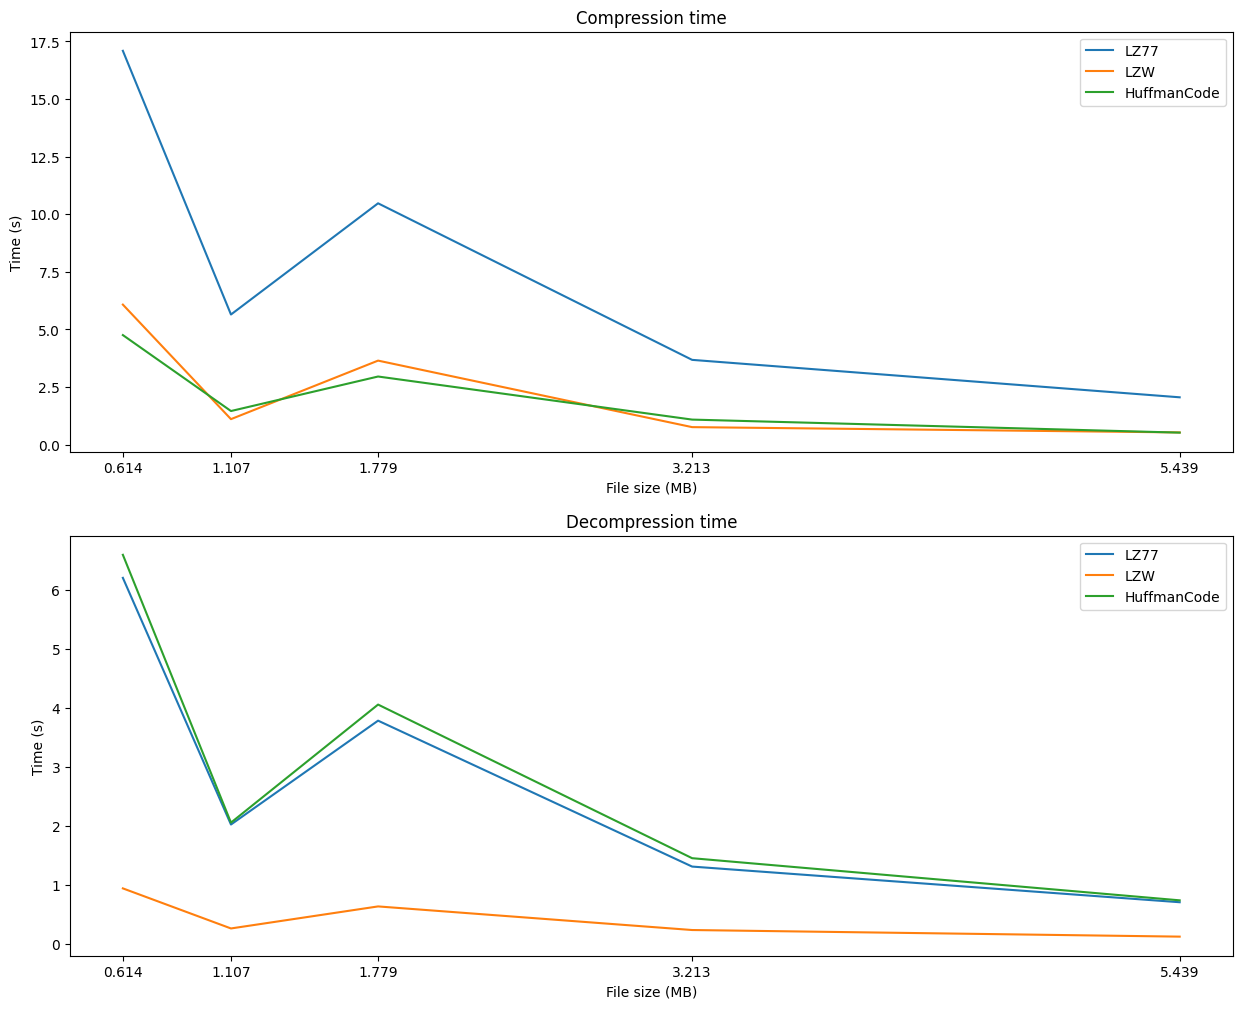

In [94]:
def plot_timing(timig_results, test_set_labels) -> None:
    """
    Function that plots the timing of the algorithms.
    """
    fig, [ax_compress, ax_decompress]= plt.subplots(2, 1, figsize=(15, 12))

    ax_compress.set_title("Compression time")
    ax_compress.set_xlabel("File size (MB)")
    ax_compress.set_ylabel("Time (s)")
    ax_compress.set_xticks(test_set_labels)

    ax_decompress.set_title("Decompression time")
    ax_decompress.set_xlabel("File size (MB)")
    ax_decompress.set_ylabel("Time (s)")
    ax_decompress.set_xticks(test_set_labels)

    for algo_name, results in timig_results.items():
        ax_compress.plot(test_set_labels, results[0], label=algo_name)
        ax_decompress.plot(test_set_labels, results[1], label=algo_name)

    ax_compress.legend()
    ax_decompress.legend()

    fig.show()

plot_timing(testing_results, test_set_sizes)

### Compression ratio

C:\Users\Mykola\AppData\Local\Temp\ipykernel_18744\3756966796.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


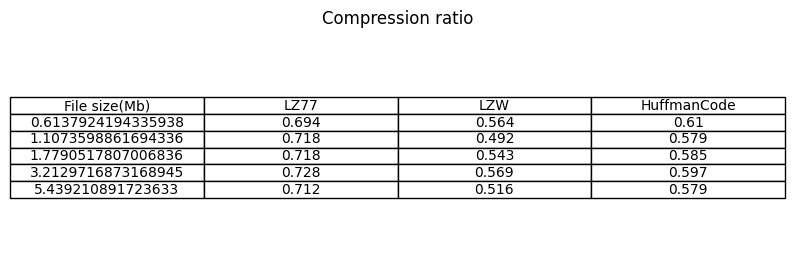

In [111]:
def compression_ration_table(timing_results, files_sizes):
    """
    Function that plots the compression ratio of the algorithms.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    cols_names = ["File size(Mb)"] + list(timing_results.keys())
    rows = []

    for idx, size in enumerate(files_sizes):
        rows.append([size] + [timing_results[algo_name][2][idx] for algo_name in timing_results.keys()])

    ax.set_title("Compression ratio")
    ax.axis("tight")
    ax.axis("off")

    ax.table(cellText=rows, colLabels=cols_names, loc="center", cellLoc="center") 
    fig.show()

compression_ration_table(testing_results, test_set_sizes)

### Short summary

**LZ77** is the most efficient algorithm and the slowest because of size of buffer(**8192** bytes). **Huffman** is almost equal to **LZ77** in decomression. His main bottleneck is a build of the Huffman tree. **LZW** as we can see is quite good in both compression and decompression but have lower compression ratio. It is due to limitation of his dictionary size.

### What about Deflate?

We implemented simplified Deflate algorithm and he works, but it is not effective. In original implementation he requires to split file to blocks and compress each block separately. We tried to implement this, but we faced with the problem of the size of the dictionary. Number of triples from LZ77 can be very large, so size of Huffman codes for each block can be very large(more than 8 bits). If we split to blocks then we have to store dictionary for each block, and this do not solve the problem. 

In [71]:
deflate_results = time_size_check(Deflate(), "books/1.txt")

print(" -- Deflate --\n")
print(f"Compression time: {deflate_results[0][0]}")
print(f"Decompression time: {deflate_results[0][1]}")
print("----------------------------------")
print(f"Original size: {deflate_results[1][0] / 1024 ** 2} Mb")
print(f"Compressed size: {deflate_results[1][1] / 1024 ** 2} Mb")

 -- Deflate --

Compression time: 13.020259799901396
Decompression time: 16.22949159995187
----------------------------------
Original size: 5.439210891723633 Mb
Compressed size: 8.253035545349121 Mb


## P.S.
Thank you for reading this report. It was very intresting laboratory work. We hope you will enjoy our work.